In [1]:
# Make sure that you have all these libaries available to run the code successfully
from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

2025-06-29 03:17:06.984431: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-29 03:17:06.984897: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 03:17:06.987263: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-29 03:17:06.993219: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751138227.002901 3229313 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751138227.00

In [2]:
data_source = 'alphavantage'

In [3]:
if data_source == 'alphavantage':
    # ====================== Loading Data from Alpha Vantage ==================================

    api_key = '4MFYSPOPV210V5WT'

    # American Airlines stock market prices
    ticker = "AAL"

    # JSON file with all the stock market data for AAL from the last 20 years
    url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

    # Save data to this file
    file_to_save = 'stock_market_data-%s.csv'%ticker

    # If you haven't already saved data,
    # Go ahead and grab the data from the url
    # And store date, low, high, volume, close, open values to a Pandas DataFrame
    if not os.path.exists(file_to_save):
        with urllib.request.urlopen(url_string) as url:
            data = json.loads(url.read().decode())
            # extract stock market data
            data = data['Time Series (Daily)']
            df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
            for k,v in data.items():
                date = dt.datetime.strptime(k, '%Y-%m-%d')
                data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                            float(v['4. close']),float(v['1. open'])]
                df.loc[-1,:] = data_row
                df.index = df.index + 1
        print('Data saved to : %s'%file_to_save)        
        df.to_csv(file_to_save)

    # If the data is already there, just load it from the CSV
    else:
        print('File already exists. Loading data from CSV')
        df = pd.read_csv(file_to_save)

else:

    # ====================== Loading Data from Kaggle ==================================
    # You will be using HP's data. Feel free to experiment with other data.
    # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
    df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
    print('Loaded data from the Kaggle repository')

File already exists. Loading data from CSV


In [4]:
# Sort DataFrame by date
df = df.sort_values('Date')

# Double check the result
df.head()


,Unnamed: 0,Date,Low,High,Close,Open
4968,0,2005-09-27,19.10,21.40,19.30,21.05
4967,1,2005-09-28,19.20,20.53,20.50,19.30
4966,2,2005-09-29,20.10,20.58,20.21,20.40
4965,3,2005-09-30,20.18,21.05,21.01,20.26
4964,4,2005-10-03,20.90,21.75,21.50,20.90


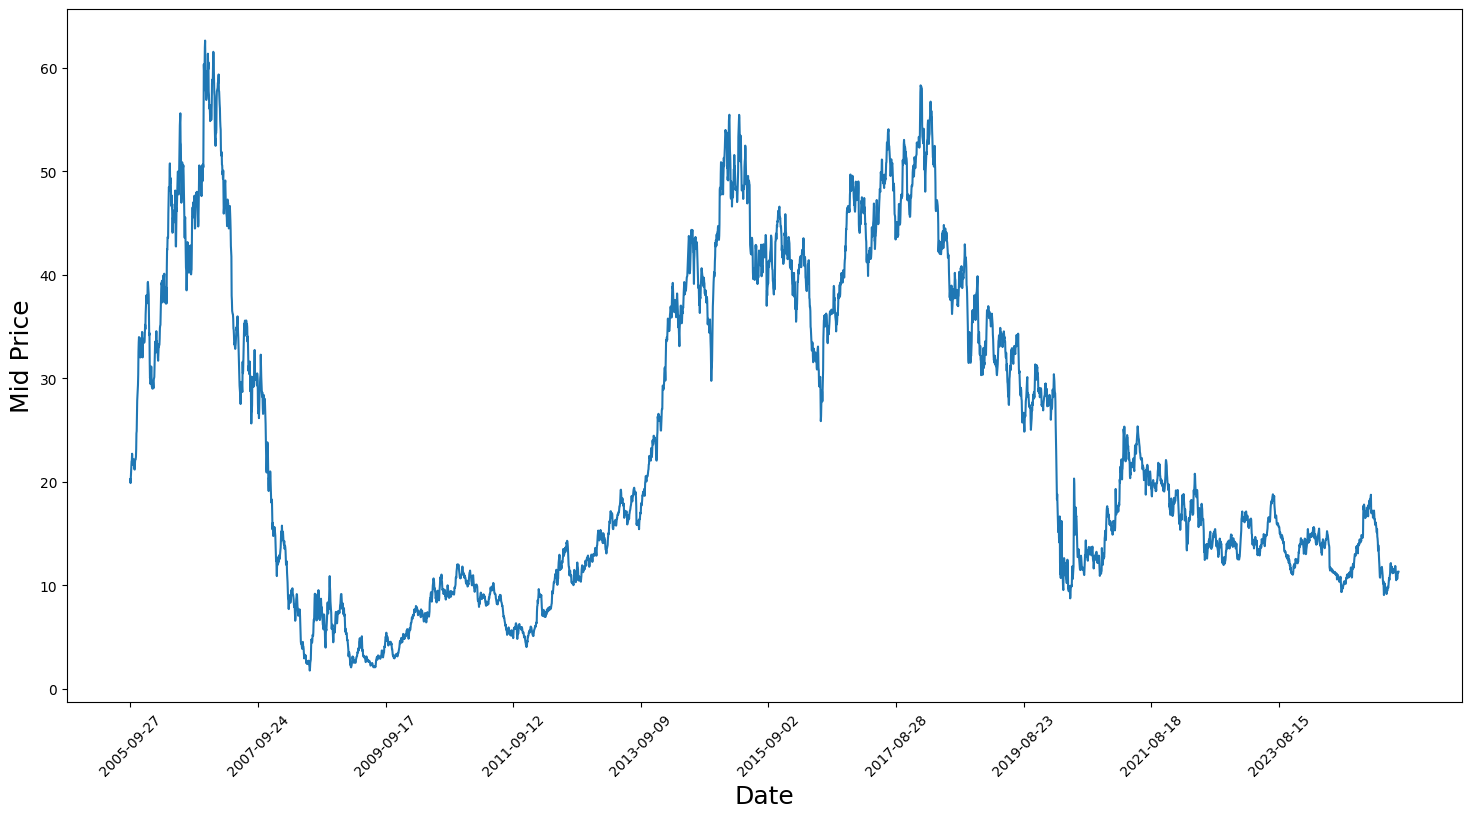

In [5]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()


In [6]:
# First calculate the mid prices from the highest and lowest
high_prices = df['High']
low_prices = df['Low']
mid_prices = (high_prices + low_prices) / 2.0

In [7]:
mid_prices

4968    20.250
4967    19.865
4966    20.340
4965    20.615
4964    21.325
         ...  
4       10.635
3       11.280
2       11.200
1       11.200
0       11.300
Length: 4969, dtype: float64

In [8]:
train_data = mid_prices[:3000]
test_data = mid_prices[3000:]


In [9]:
train_data.shape, test_data.shape

((3000,), (1969,))

In [10]:
# Scale the data to be between 0 and 1
scaler = MinMaxScaler()
train_data = train_data.to_numpy().reshape(-1,1)
test_data = test_data.to_numpy().reshape(-1,1)

In [11]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 100
for di in range(0,2900,smoothing_window_size):
    scaler.fit(train_data[di:di+smoothing_window_size,:])
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


In [12]:
# Reshape both train and test data
train_data = train_data.reshape(-1)

# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)


In [13]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(3000):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)


In [16]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00316


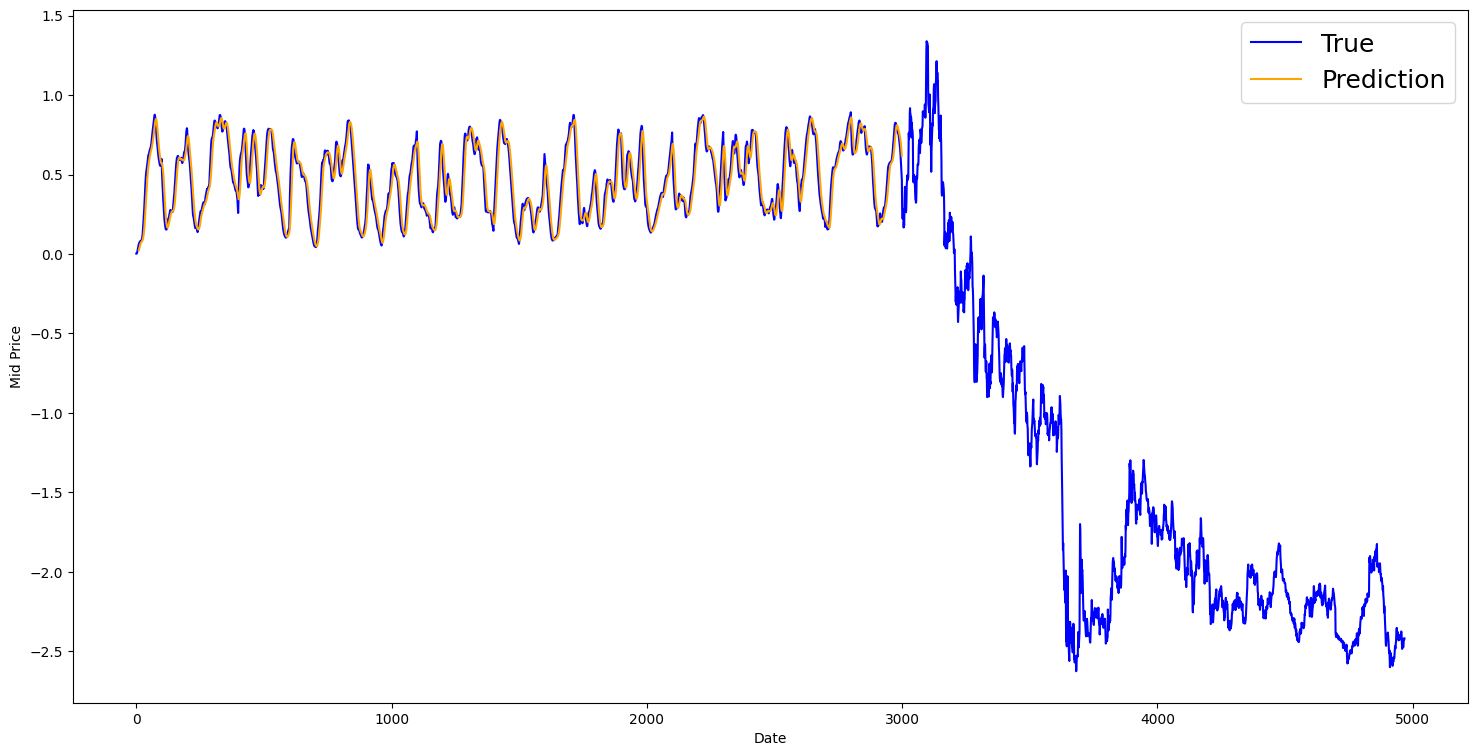

In [17]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [18]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for EMA averaging: 0.00051


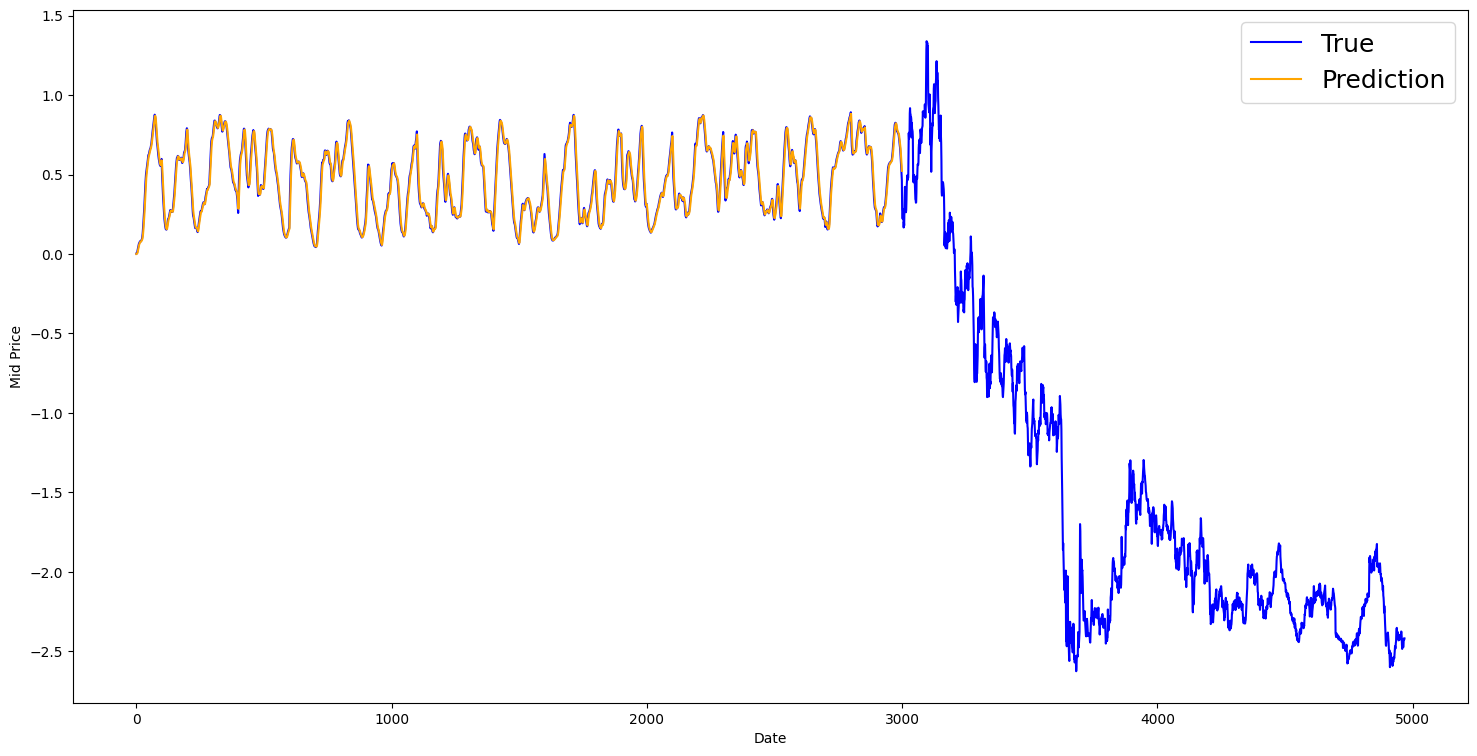

In [19]:

plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()


In [20]:

class DataGeneratorSeq(object):

    def __init__(self,prices,batch_size,num_unroll):
        self._prices = prices
        self._prices_length = len(self._prices) - num_unroll
        self._batch_size = batch_size
        self._num_unroll = num_unroll
        self._segments = self._prices_length //self._batch_size
        self._cursor = [offset * self._segments for offset in range(self._batch_size)]

    def next_batch(self):

        batch_data = np.zeros((self._batch_size),dtype=np.float32)
        batch_labels = np.zeros((self._batch_size),dtype=np.float32)

        for b in range(self._batch_size):
            if self._cursor[b]+1>=self._prices_length:
                #self._cursor[b] = b * self._segments
                self._cursor[b] = np.random.randint(0,(b+1)*self._segments)

            batch_data[b] = self._prices[self._cursor[b]]
            batch_labels[b]= self._prices[self._cursor[b]+np.random.randint(0,5)]

            self._cursor[b] = (self._cursor[b]+1)%self._prices_length

        return batch_data,batch_labels

    def unroll_batches(self):

        unroll_data,unroll_labels = [],[]
        init_data, init_label = None,None
        for ui in range(self._num_unroll):

            data, labels = self.next_batch()    

            unroll_data.append(data)
            unroll_labels.append(labels)

        return unroll_data, unroll_labels

    def reset_indices(self):
        for b in range(self._batch_size):
            self._cursor[b] = np.random.randint(0,min((b+1)*self._segments,self._prices_length-1))



dg = DataGeneratorSeq(train_data,5,5)
u_data, u_labels = dg.unroll_batches()

for ui,(dat,lbl) in enumerate(zip(u_data,u_labels)):   
    print('\n\nUnrolled index %d'%ui)
    dat_ind = dat
    lbl_ind = lbl
    print('\tInputs: ',dat )
    print('\n\tOutput:',lbl)




Unrolled index 0
	Inputs:  [0.00197994 0.16170931 0.6641698  0.52664876 0.6283119 ]

	Output: [0.00197994 0.31948686 0.5113785  0.52664876 0.6283119 ]


Unrolled index 1
	Inputs:  [0.00178195 0.24537009 0.64636713 0.51547575 0.6071363 ]

	Output: [0.00178195 0.4460961  0.49112502 0.5079841  0.593439  ]


Unrolled index 2
	Inputs:  [0.00404654 0.31948686 0.5817304  0.5079841  0.5896637 ]

	Output: [0.02365705 0.31948686 0.53675467 0.41462716 0.60641426]


Unrolled index 3
	Inputs:  [0.00749892 0.3845512  0.53675467 0.45718572 0.57108593]

	Output: [0.01425739 0.53925955 0.5113785  0.37764966 0.61896414]


Unrolled index 4
	Inputs:  [0.01425739 0.4460961  0.5113785  0.41462716 0.58523065]

	Output: [0.05139436 0.53925955 0.49112502 0.37764966 0.61896414]


In [22]:
D = 1 # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50 # Number of time steps you look into the future.
batch_size = 500 # Number of samples in a batch
num_nodes = [200,200,150] # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes) # number of layers
dropout = 0.2 # dropout amount

# tf.reset_default_graph() # This is important in case you run this multiple times


In [24]:
# Input data - using variables that will be updated during training
train_inputs, train_outputs = [], []

# For TensorFlow 2.x, you typically don't need placeholders
# Instead, you can use tf.Variable or just pass data directly to your model
for ui in range(num_unrollings):
    # Create variables that can be updated
    train_inputs.append(tf.Variable(tf.zeros([batch_size, D]), trainable=False, name='train_inputs_%d'%ui))
    train_outputs.append(tf.Variable(tf.zeros([batch_size, 1]), trainable=False, name='train_outputs_%d'%ui))

E0000 00:00:1751138499.836573 3229313 cuda_executor.cc:1228] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1751138499.839656 3229313 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [26]:
# Updated code for TensorFlow 2.x
lstm_cells = [
    tf.keras.layers.LSTMCell(units=num_nodes[li])
    for li in range(n_layers)
]

# For dropout, you can use tf.keras.layers.Dropout or handle it in the LSTM layer directly
drop_lstm_cells = [
    tf.keras.layers.LSTMCell(
        units=num_nodes[li],
        dropout=dropout,
        recurrent_dropout=dropout
    )
    for li in range(n_layers)
]

# For stacked LSTM layers, use tf.keras.layers.StackedRNNCells
drop_multi_cell = tf.keras.layers.StackedRNNCells(drop_lstm_cells)
multi_cell = tf.keras.layers.StackedRNNCells(lstm_cells)

# For weights and biases, use tf.Variable with proper initializers
w = tf.Variable(
    tf.random.normal([num_nodes[-1], 1]) * tf.sqrt(2.0 / num_nodes[-1]),  # Xavier initialization
    name='w'
)
b = tf.Variable(
    tf.random.uniform([1], -0.1, 0.1),
    name='b'
)